# Applying Novel Approaches to Predict Yelp Ratings

## Synopsis

In our research we explore both traditional and novel methods for predicting user ratings on the domain of Yelp restaurants. We provide a prospective restaurant advertiser/marketer/researcher a detailed comparison of the advantages/disadvantages between prediction methods and suggest practical considerations for their real-world usage.

Keywords: Machine Learning; Collaborative Filtering; Ensemble Models; Factorization Machines

#### Contributors:
- EK Itoku | UNI: ii2155 | Email: ii2155@columbia.edu
- Jason Kuo | UNI: jk4097 | Email: jk4097@columbia.edu
- Sean Xu | UNI: cx2118 | Email: cx2118@columbia.edu


#### Report Layout:

* Objectives
* Data Extraction and Feature Engineering
* Evaluation Metrics
* Recommendation Approaches and Analysis of Results
    + Accuracy Across User Distributions
    + Accuracy Across Restaurant Distributions
    + Recommendation Coverage
* Implementation Considerations
* Conclusions and Takeaways
* References

In [3]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [30]:
import os
import numpy as np
import pickle
import pandas as pd
from source.utils import plot_lines, create_quantile_bucket, rmse, calculate_catalog_coverage
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

pd.options.display.float_format = "{:4.2f}".format
%matplotlib inline

## Objectives

In this study we aim to predict the rating of the last restaurant a Yelp user visits. A rating is on the scale of 1 - 5 with 5 representing great. For marketing companies, this can be invaluable in identifying potential users who will like a targeted restaurant and only focus advertising to those users with high predicted ratings. For any potential recommendation method, we want to carefully consider accuracy on the whole model and across different populations, implementation time and complexity. In addition, for consideration of using this method as a recommender of new restaurants to try, factoring the diversity of recommendations in our assessment is valuable.

## Data Extraction and Feature Engineering
Yelp has generously provided a rich amount of information on the reviews on its site to academic researchers. We decided to utilize the business and user data in addition to the reviews file in hopes of enriching the model with contextual information to improve rating predictions.

After performing exploratory data analysis on the business file, we decided to focus solely on restaurants as it was the main business category and what we believe most users come to the site to solicit recommendations on. Yelp provides a multi-label category classification of each business of which we applied a filter to detect businesses with a ‘restaurant’ label as one of its categories. From there we one-hot-encoded the accompanying categories such as type of cuisine and whether it was also considered a bar by keeping the categories that show up in at least 1% of the data. We also identified non-US businesses by observing alphanumeric zip codes such as those in Canada. We decided to focus on the US market by filtering for US-zip code patterns as the international data collected and real-world usage was limited. We removed any businesses marked as closed in order to train the model to generate potential recommendations drawing from currently available establishments. Finally, we set a minimum of 50 reviews for a business ensure a sufficient amount of data to properly learn from our users.

Looking into the users file, we applied a similar filter of keeping users with at least 5 reviews to draw experience from. We constructed a few features such as total user compliments, number of elite year status and how many years Yelping in order to better fit into our models.
The reviews file we took mostly as default aside from seeing if the number of props (‘useful’, ‘funny’, ‘cool’ likes) on the given review impacted the rating.

## Evaluation Metrics

To achieve our objective, we used two different evaluation schemes:


#### - Root Mean Squared Error (Primary Benchmark)

We use the root mean squared error benchmark (RMSE) to measure the deviation of our predicted rating from the true rating in our testing set. A lower result is better signaling less prediction error.


#### - Mean Absolute Error (Secondary Benchmark)

RMSE penalizes the larger deviations from the true rating more than similarly spaced apart smaller deviations when the total amount of deviation is the same. Mean Absolute Error (MAE) measures all deviations similarly. 


#### - Coverage Metric
To estimate recommendation coverage, we decided to recommend the top 20 restaurants for a user by predicted rating and compare the universe of recommendations of all users vs. the total amount of establishments. Due to the sheer number of users in our dataset (>235k unique profiles) and the number of restaurants to predict against (>11k) we decided to sample 5k users as a representative set to manage prediction time. While not as ideal as using the entire dataset, by applying the same methodology across all our models we can compare and contrast their differences.

## Recommendation Approaches and Analysis of Results

### 1) Baseline (Bias Model)

A bias model can prove to be a strong baseline if rating behavior tends to drift towards large averages and the wisdom of crowds.

*Methodology:*

<img src="image/baseline1.png" alt="drawing" width="200"/>
Where we adjust the mean rating of all users and all items by the observed deviations of user u and item i.

In order to avoid overfitting, we add regularizations by penalizing the magnitudes of the parameters.
<img src="image/baseline2.png" alt="drawing" width="400"/>

In Surprise implementation, for easier calculation, it decouples the calculation of b_u and b_i. For b_i
<img src="image/baseline3.png" alt="drawing" width="300"/>

For b_u
<img src="image/baseline4.png" alt="drawing" width="300"/>

And Surprise provides two algorithms to calculate the parameters: Baselines can be estimated in two different ways:
* Stochastic Gradient Descent (SGD)
* Alternating Least Squares (ALS)

We run a GridSearch for both algorithms on accuracy matrix including:
* Primary: RMSE
* Secondary: MAE

*Final Tuned Results:*

Algorithm | Model with least RMSE | RMSE | Model with least MAE | MAE
----------|-----------------------|------|----------------------|----
ALS|'n_epochs': 30, 'reg_u': 10, 'reg_i': 10|1.15|'n_epochs': 30, 'reg_u': 10, 'reg_i': 10 |0.92
SGD|'n_epochs': 30, 'reg': 0.1, 'learning_rate': 0.005|1.15|'n_epochs': 30, 'reg': 0.01, 'learning_rate': 0.01|0.90


### 2) Individual and Ensemble Methods

#### Individual models
We considered several collaborative filtering models individually and then ensembling them including:
- Baseline-only
- KNN (Basic and With Means)
- SVD
- Co-clustering

##### • KNN (Memory-based Collaborative Filtering)
The idea is to use collaborative filtering to find similar users or items to help predict the rating of given user and item. 

*Methodology:*


<img src="image/knn1.png" alt="drawing" width="300"/>
<img src="image/knn2.png" alt="drawing" width="300"/>

There are several ways to calculate the similarities including cosine, pearson and msd.

The hyperparameter tuning results for a traditional KNN and a K-means approach are as follows:

*Final Tuned Results:*

Algorithm|Model with least RMSE|RMSE|Model with least MAE|MAE
---------|---------------------|----|--------------------|---
KNN|‘similarity_method’: cosine, 'k': 40|1.50|‘similarity_method’: msd, 'k': 20|1.12
K-Means|‘similarity_method’: cosine, 'k': 40|1.39|‘similarity_method’: cosine, 'k': 40|1.05

##### • Matrix Factorization - SVD (Model-based Collaborative Filtering)
A matrix factorization method which is popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization. 

*Methodology:*


Details can be found in the article: https://sifter.org/~simon/journal/20061211.html

*Final Tuned Results:*

Model with least RMSE|RMSE|Model with least MAE|MAE
---------------------|----|--------------------|---
'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1|1.13|'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1|0.89


##### • Co-Clustering (Model-based Collaborative Filtering)

Users and items are assigned in cluster assignments which are done by basic techniques like K-means. The model fills in the unobserved rating gaps in the user and item matrix by using averaging actual user-item ratings and estimated ratings by combining the average rating of the individual user's and item's clusters similar to a bias model.

*Methodology:*


<img src="image/cocluster.png" alt="drawing" width="600"/>

Details can be found in the paper: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf

*Final Results:*

Unfortunately we were unable to tune the hyperparameters with our current hardware. Below are un-tuned aggregate stats:

Model           |RMSE|MAE
----------------|----|---
Co-Clustering |1.26|0.94

#### Ensemble

The idea of ensemble model is to stack a set of basic recommendation models and use the weighted sum of the predictions as the new prediction which ideally will remove the flaws in individual implementation.
* Averaging
* Weighted Average (Train weights with linear regression and ElasticNet regression)

*Methodology:*

1. Tune the hyperparameter of base models
2. Train base models using the tuned hyperparameters
3. Run regression to learn the weights or use a simple average
4. Stack models together with weights (average or trained weights)

*Final Tuned Results:*

Model | RMSE
------|-----
Base Models|1.13 - 1.33
Ensemble with average weights|1.32
Ensemble with weights learned from linear regression|1.32
Ensemble with weights learned from ElasticNet|1.39

Model | MAE
------|----
Base Models|0.9 - 1
Ensemble with average weights|1.05
Ensemble with weights learned from linear regression|1.03
Ensemble with weights learned from ElasticNet|1.11

### 3) Factorization Machines

Factorization Machines are a state of the art solution to recommendation problems. In theory, FMs should produce better results than MF due to interaction terms but in practice it might not necessary be the case. If side information is omitted, then FMs become the same as the MF model.

*Methodology:*

FMs are similar to collective approaches allowing for multiple relationships between entities but differ in:
- FMs use a clever feature representation to cast factorization as a regression, classification, or ranking problem
- In addition to relations between entities, FMs allow for interaction terms for items within a single entity type
- FMs can be defined such that they act like, or mimic, other techniques like SVD++

Details can be found in the paper: https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf

In addition to hyperparameter tuning, we have tested various configurations of the feature set.

*Final Tuned Results:*

Algorithm | Model Parameters | Model Features | RMSE | MAE
----------|-----------------------|------|----------------------|----
FM|'task':'reg', 'lr':0.5,'lambda':0, 'metric':'rmse', 'k':20, 'epoch':20| OHE 'user_id', OHE 'business_id', 'user_review_count', 'user_elite', 'user_fans', 'user_average_stars', 'user_compliment', 'user_yelping_years', OHE 'restaurant_categories' |1.257405 | 1.011706

## Accuracy Across User Distributions 

You may be asking, do our methods work equally well for all users?

We will evaluate methods from two different angles:
##### 1. In terms of number of ratings users provided
The more users review restaurants, the better our predictions perform. This is intuitive as there are more samples models to learn, we can train models better. The baseline model was superior across most methods but FM was notable that it was able to provide resonable prediction accuracy for users with fewer ratings.


##### 2. In terms of attaining elite status
Our experiments show that our methods perform better for elite users. For example, MAE is 0.78 for elite users whereas 1.03 for non-elite users. We think this is because there are more samples for elite users. Another possibility is that there might be some spam users or malicious business accounts that rate restaurants in an unusual manner.

In [13]:
cols = [
    "user_id",
    "business_id",
    "review_stars",
    "user_average_stars",
    "user_review_count",
    "user_elite",
    "user_fans",
    "business_stars",
    "business_review_count",
]
truth = pd.read_csv("data/feature.csv", usecols=cols)
all_businesses = truth.business_id.unique()

In [6]:
model_result_files = [
    "baseline_pred.pkl",
    "knnwithmeans_pred.pkl",
    "svd_pred.pkl",
    "coclustering_pred.pkl",
    "knnbasic_pred.pkl",
    "ensemble_pred.pkl",
    "fm_pred.pkl",
]
preds = []

for fn in model_result_files:
    pred = pd.read_pickle(f"result/{fn}")
    pred = pred.merge(truth, on=["user_id", "business_id"], how="inner")

    pred["squared_error"] = (pred.review_stars - pred.y_pred) ** 2
    pred["absolute_error"] = (pred.review_stars - pred.y_pred).abs()

    preds.append([fn.split("_")[0], pred])

In [7]:
# 1. In terms of number of ratings users provided

for nm, pred in preds:
    pred["user_review_count_bin"] = pd.qcut(pred.user_review_count, 10)
    desc = pred.groupby("user_review_count_bin").absolute_error.describe()
    print(nm)
    print(desc)
    print()
    print()

baseline
                         count  mean  std  min  25%  50%  75%  max
user_review_count_bin                                             
(4.999, 7.0]          35329.00  1.12 0.81 0.00 0.51 0.95 1.59 4.00
(7.0, 9.0]            24570.00  1.10 0.82 0.00 0.46 0.92 1.56 4.00
(9.0, 11.0]           20224.00  1.07 0.80 0.00 0.45 0.90 1.52 4.00
(11.0, 14.0]          23186.00  1.04 0.79 0.00 0.43 0.87 1.49 4.00
(14.0, 18.0]          22003.00  1.02 0.79 0.00 0.42 0.86 1.45 4.00
(18.0, 25.0]          24238.00  1.01 0.79 0.00 0.39 0.84 1.45 4.00
(25.0, 38.0]          23846.00  0.98 0.78 0.00 0.38 0.81 1.40 4.00
(38.0, 68.0]          24415.00  0.93 0.75 0.00 0.36 0.77 1.31 4.00
(68.0, 161.0]         24665.00  0.88 0.70 0.00 0.35 0.72 1.23 4.00
(161.0, 13278.0]      24647.00  0.79 0.63 0.00 0.31 0.66 1.10 4.00


knnwithmeans
                         count  mean  std  min  25%  50%  75%  max
user_review_count_bin                                             
(4.999, 7.0]          35329.00  1.18 1

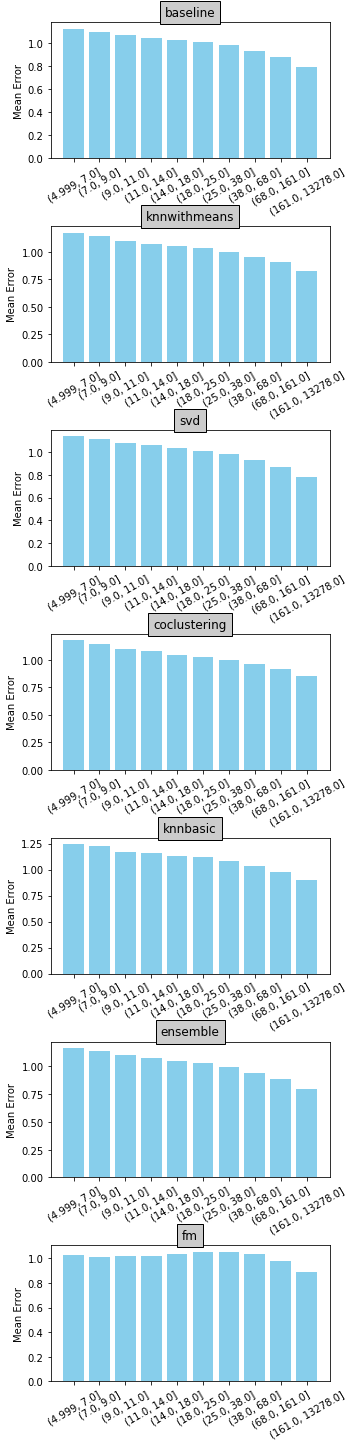

In [8]:
# plot mean error for comparison

fig = plt.figure()
fig.set_size_inches(5, 25)
count=1
for nm, pred in preds:
    pred["user_review_count_bin"] = pd.qcut(pred.user_review_count, 10)
    desc = pred.groupby("user_review_count_bin").absolute_error.describe()
    ax  = fig.add_subplot(7,1,count)
    ax.bar([str(_) for _ in desc.index.tolist()], desc['mean'], color='skyblue')
    # ax.set_xticks(ind)
    ax.set_xticklabels([str(_) for _ in desc.index.tolist()],rotation=30)
    ax.set_ylabel('Mean Error')
    ax.set_title(model_result_files[count-1].split("_")[0], bbox={'facecolor':'0.8', 'pad':5})
    count+=1
plt.subplots_adjust(hspace=0.5)
plt.show()

In [9]:
# 2. In terms of attaining elite status

for nm, pred in preds:
    pred.user_elite = pred.user_elite > 0
    desc = pred.groupby("user_elite").absolute_error.describe()
    print(nm)
    print(desc)
    print()
    print()

baseline
               count  mean  std  min  25%  50%  75%  max
user_elite                                              
False      213281.00  1.03 0.79 0.00 0.42 0.86 1.47 4.00
True        33842.00  0.78 0.63 0.00 0.31 0.64 1.09 4.00


knnwithmeans
               count  mean  std  min  25%  50%  75%  max
user_elite                                              
False      213281.00  1.07 0.93 0.00 0.31 0.88 1.54 4.00
True        33842.00  0.81 0.69 0.00 0.29 0.66 1.15 4.00


svd
               count  mean  std  min  25%  50%  75%  max
user_elite                                              
False      213281.00  1.04 0.77 0.00 0.46 0.87 1.44 4.00
True        33842.00  0.77 0.62 0.00 0.31 0.65 1.07 4.00


coclustering
               count  mean  std  min  25%  50%  75%  max
user_elite                                              
False      213281.00  1.07 0.97 0.00 0.26 0.88 1.57 4.00
True        33842.00  0.83 0.71 0.00 0.29 0.68 1.16 4.00


knnbasic
               count  mean  std 

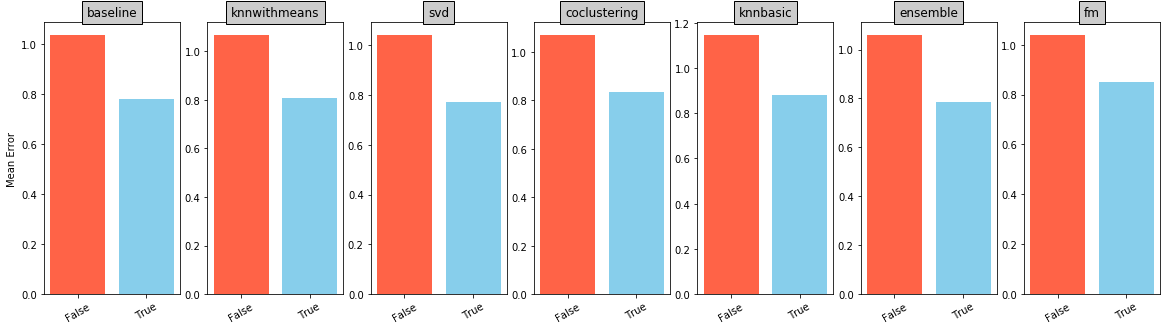

In [10]:
# plot mean error for comparison

fig = plt.figure()
fig.set_size_inches(20, 5)
count=1
for nm, pred in preds:
    pred.user_elite = pred.user_elite > 0
    desc = pred.groupby("user_elite").absolute_error.describe()
    ax  = fig.add_subplot(1,7,count)
    ax.bar([str(_) for _ in desc.index.tolist()], desc['mean'], color=['tomato','skyblue'])
    # ax.set_xticks(ind)
    ax.set_xticklabels([str(_) for _ in desc.index.tolist()],rotation=30)
    if count==1:
        ax.set_ylabel('Mean Error')
    ax.set_title(model_result_files[count-1].split("_")[0], bbox={'facecolor':'0.8', 'pad':5})
    count+=1
plt.show()

## Accuracy Across Restaurant Distributions 

Similarly, you may be asking, do our methods work equally well for all restaurants?

Our methods perform better for the restaurants that are popular with more reviews. Similar to the user analysis above, the methods perform better if there are more data to learn patterns on which is highly intuitive. 

In [51]:
for nm, pred in preds:
    pred["business_review_count_bin"] = pd.qcut(pred.business_review_count, 10)
    desc = pred.groupby("business_review_count_bin").absolute_error.describe()
    print(nm)
    print(desc)
    print()
    print()

baseline
                             count  mean  std  min  25%  50%  75%  max
business_review_count_bin                                             
(49.999, 84.0]            25035.00  1.10 0.80 0.00 0.47 0.96 1.59 4.00
(84.0, 125.0]             24420.00  1.05 0.78 0.00 0.44 0.89 1.50 4.00
(125.0, 173.0]            25025.00  1.06 0.78 0.00 0.44 0.90 1.52 4.00
(173.0, 236.0]            24782.00  1.03 0.78 0.00 0.43 0.86 1.47 4.00
(236.0, 313.0]            24431.00  1.02 0.79 0.00 0.41 0.84 1.45 4.00
(313.0, 413.0]            24706.00  1.00 0.78 0.00 0.41 0.83 1.40 4.00
(413.0, 555.0]            24662.00  0.98 0.77 0.00 0.39 0.80 1.37 4.00
(555.0, 851.0]            24650.00  0.97 0.77 0.00 0.38 0.78 1.35 4.00
(851.0, 1476.0]           24765.00  0.90 0.75 0.00 0.36 0.72 1.22 4.00
(1476.0, 8348.0]          24647.00  0.87 0.71 0.00 0.34 0.72 1.19 4.00


knnwithmeans
                             count  mean  std  min  25%  50%  75%  max
business_review_count_bin                            

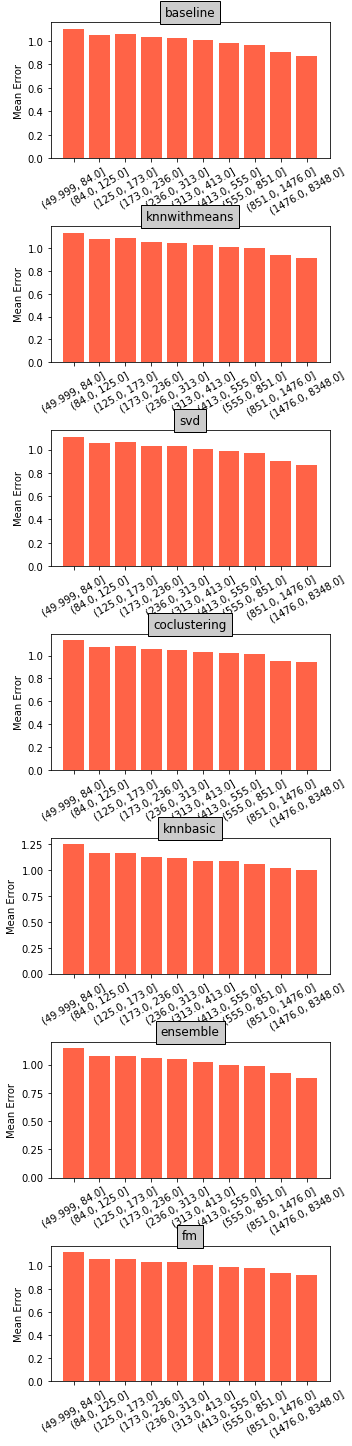

In [11]:
# plot mean error for comparison

fig = plt.figure()
fig.set_size_inches(5, 25)
count=1
for nm, pred in preds:
    pred["business_review_count_bin"] = pd.qcut(pred.business_review_count, 10)
    desc = pred.groupby("business_review_count_bin").absolute_error.describe()
    ax  = fig.add_subplot(7,1,count)
    ax.bar([str(_) for _ in desc.index.tolist()], desc['mean'], color='tomato')
    # ax.set_xticks(ind)
    ax.set_xticklabels([str(_) for _ in desc.index.tolist()],rotation=30)
    ax.set_ylabel('Mean Error')
    ax.set_title(model_result_files[count-1].split("_")[0], bbox={'facecolor':'0.8', 'pad':5})
    count+=1
plt.subplots_adjust(hspace=0.5)
plt.show()

## Recommendation Coverage

As highlighted in our objectives, if we want to use the model as a recommender of new restaurants to try, we should assess the diversity of the recommendations provided to our users.

baseline: 21.71%
knnbasic: 99.84%
knnwithmeans: 85.57%
coclustering: 78.95%
svd: 17.2%
ensemble: 13.43%
fm: 0.82%


Text(0.5, 1.0, 'Top K Coverage')

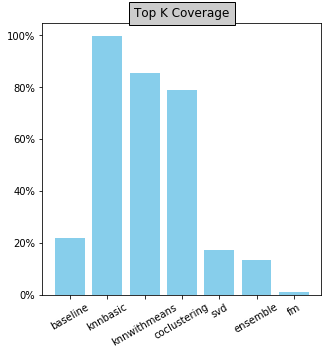

In [41]:
file_names = [
    'baseline_top_20.pkl', 
    'knnbasic_top_20.pkl',
    'knnwithmeans_top_20.pkl',
    'coclustering_top_20.pkl',
    'svd_top_20.pkl',
    'ensemble_top_20.pkl',
    'fm_top_20.pkl',
]

top_20_coverage = {}
for fn in file_names:
    pred = pd.read_pickle(f"result/{fn}")
    coverage = calculate_catalog_coverage(all_businesses, pred)
    top_20_coverage[fn.split("_")[0]]=coverage*100
    print(fn.split("_")[0] + ":" , str(round(coverage*100,2))+'%')
    
top_20_coverage_df = pd.DataFrame.from_dict(top_20_coverage,'index').stack().reset_index(level=0).rename(columns={'level_0':'algorithm',0:'top_k_coverage'})
fig = plt.figure()
fig.set_size_inches(5, 5)
ax  = fig.add_subplot(111)
ax.bar(top_20_coverage_df.algorithm, top_20_coverage_df.top_k_coverage, color='skyblue')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_xticklabels(top_20_coverage_df.algorithm,rotation=30)
ax.set_title('Top K Coverage', bbox={'facecolor':'0.8', 'pad':5})

Coverage scores for the methods were across the board for the models, with KNN having an extremely high score and FM being extremely low. This highlights the difference in providing diverse, personalized recommendations to users between methodologies.

## Implementation Considerations

For Yelp or any other resturant recommendation business looking to employ one of these methods into real-world use, they should consider the following:

#### New Users

With no existing data, it is question on how to provide an appropriate recommendation for new users. One suggestion is to factor elite user's recommendations more heavily that non-elites as the model has learned to predict better on the expected rating of experts. Identifying the top 20 nearest elites to the user and taking their highest average recommended score of resturants can prove to be a more reliable recommendation. In addition, factorization machines appear to have promise in generalizing user preferences better than baseline bias models for less active years.


#### Model Complexity

As shown through our results, a properly set up simple bias model may provide great results with less implementation risk and training time than a more complicated model with varying degrees of improvement. Yelp may favor simplifying the processing pipeline in order to avoid having to make too many assumptions in more sophisticated feature engineering.


#### Recommendation Diversity

Recommendation diversity, as measured by our coverage metric, can be a notable consideration. Yelp could favor a high level of coverage across their catalogue to highlight the diversity of their platform. If they could recommend more hole-in-the-wall or niche restaurants while providing high levels of user engagement then they could convince smaller establishments to pay for more targeted advertising with the premise of being more likely shown.


## Conclusions and Takeaways

*Performance Summary:*

Algorithm | RMSE | MAE | Training Time | Coverage
---------|------|-----|---------------|----------
Baseline|1.15|0.90|12.69|21.7%
kNNBasic|1.50|1.12|20.15|99.8%
kNNwithMeans|1.39|1.05|21.04|85.6%
SVD|1.13|0.89|38.98|17.2%
Co-Clustering|1.26|0.94|47.33|78.9%
Ensemble-Average|1.32|1.05|187.12|DNR, favoring LinReg by acc
Ensemble-LinearRegression|1.32|1.03|202.25|13.4%
Ensemble-ElasticNet|1.39|1.11|234.61|DNR, favoring LinReg by acc
Factorization Machine|1.26|1.01|23.19|0.8%

We have assessed a variety of traditional and novel recommendation approaches to provide resturant rating predictions for users with a varying amount of previous rating history. From our results, we can see that many of the methods had difficulty beating our baseline recommender accuracy numbers using a bias model. SVD was our best method in terms of accuracy which can indicate that more recent recommendation advances since the Netflix Prize competition in 2007 may have made limited progress. We have seen that contextual information has promise in improving prediction accuracy for less active users as evidenced in the factorization machine model. 

In terms of other practical considerations outside of accuracy, we have seen that intuitively the simple baseline bias model had the fastest training time while the ensemble methods took the longest. For scaling considerations it may not be practical to utilize too large of an ensemble model. Finally, the KNN-based methods provide very high recommendation diversity over all the other methods which could be an important factor when considering generating new recommendations for users as an use case.

In conclusion, we provided practical implementation considerations for Yelp to adopt and expand on our approaches. We have also developed an end-to-end pipeline from data extraction to built models for Yelp to explore. 

Looking forward, the researchers would like to continue to investigate the impact of incorporating additional features to supplement the predictions of users with fewer ratings. Prospective areas to explore include factoring local geography of the resturants, identifying local experts who can influence other users more strongly via a relational network or running NLP on the review texts to understand personal preferences.


## References

1: https://towardsdatascience.com/precision-vs-recall-386cf9f89488

2: https://surprise.readthedocs.io/en/stable/index.html

3: https://xlearn-doc.readthedocs.io/en/latest/index.html

4: https://sifter.org/~simon/journal/20061211.html

5: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf

6: https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf